In [1]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [2]:
tf.__version__

'1.0.1'

In [3]:
PAD = 0
EOS = 1

vocab_size = 10 #(0~9)
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [4]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [5]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

# Embedding

In [6]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

定義embedding matrix，亂數初始化，利用end-to-end training來學習vector representation
(之後可以直接套用word2vec???)

矩陣為大小為： 單字數量 * 單字embedding(word embedding)

In [7]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

用tf.nn.embedding_lookup直接查閱embedding matrix，比方說encoder_inputs為[0,0,1,0,0,1,0,0,0,0](使用one-hot encoding，分別代表0~9的單字)
則encoder_inputs_embedded回傳word 2和word 5的word embedding

# Encoder

In [8]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

_, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)
# del encoder_outputs

在此我們只在乎encoder_final_state(LSTM的最後一個time step的hidden layer)

關於dynamic_rnn吃的參數：
dynamic_rnn(
    cell,
    inputs,
    sequence_length=None,
    initial_state=None,
    dtype=None,
    parallel_iterations=None,
    swap_memory=False,
    time_major=False,
    scope=None
)

In [9]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

Tensorflow中的LSTM利用Tuple of Tensor型態來儲存state
<li>encoder_final_state.h is activations of hidden layer of LSTM cell</li>
<li>encoder_final_state.c is final output, which can potentially be transfromed with some wrapper @TODO: check correctness</li>

# Decoder

In [10]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

需將encoder_final_state傳入到decoder的initial_state，因此他們必須是compatible(相同的cell：encoder用LSTM則decoder也用LSTM、相同的hidden units和layer個數）-> 或許可以加上one-layer MLP在final_state以relax此限制

In [11]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)
decoder_prediction = tf.argmax(decoder_logits, 2)

<li>decoder_cell output is a hidden_units sized vector at every timestep，為了將decoder_ouputs的size從原本的hidden_units size轉成vocab_size，我們放了一個線性layer作轉換</li>


# Optimizer

In [12]:
decoder_logits

<tf.Tensor 'fully_connected/Reshape_1:0' shape=(?, ?, 10) dtype=float32>

<li>RNN輸出為tensor，其shape為[max_time, batch_size, hidden_units]而後利用一個projection layer來mappint到shape為[max_time, batch_size, vocab_size]</li>
<li>vocab_size為static, max_time和batch_size是dynamic</li>

In [13]:
decoder_prediction

<tf.Tensor 'ArgMax:0' shape=(?, ?) dtype=int64>

In [14]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

關於tf.nn.softmax_cross_entropy_with_logits：
<li>參數logits：就是神經網絡最後一層的輸出，如果有batch的話，它的大小就是[batchsize, num_classes]，單樣本的話，大小就是num_classes</li>
<li>參數labels：實際的標簽，大小同上</li>
<li>注意：此函數的回傳值為一個向量，若要求loss的值須額外多做一步tf.reduce_mean

In [15]:
sess.run(tf.global_variables_initializer())

# Test forward pass
先隨便假設一組資料試試看各個dimension是否符合

In [16]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[2 2 4]
 [7 7 4]
 [7 7 4]
 [7 7 7]]


# Training on the toy task
接著我們random出簡單sample來做測試，我們現在以0~9分別代表9個單字作為範例

In [17]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[8, 3, 9, 2, 5, 3, 6]
[7, 4, 4, 5, 5, 5]
[6, 7, 4, 8, 8, 8, 9]
[3, 2, 4, 8]
[4, 6, 4, 6, 8, 3]
[4, 6, 9, 8]
[8, 2, 6, 6]
[6, 7, 8, 4, 3, 9]
[7, 3, 9, 2, 7, 8, 8]
[7, 3, 7, 3, 3]


In [18]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

Given encoder_inputs [5, 6, 7], decoder_targets would be [5, 6, 7, 1], where 1 is for EOS, and decoder_inputs would be [1, 5, 6, 7] - decoder_inputs are lagged by 1 step, passing previous token as input at current step.

In [19]:
loss_track = []

In [20]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.26916456223
  sample 1:
    input     > [7 4 6 2 4 0 0 0]
    predicted > [2 5 5 5 5 9 6 6 6]
  sample 2:
    input     > [7 3 5 6 4 0 0 0]
    predicted > [2 5 8 3 0 0 0 6 6]
  sample 3:
    input     > [3 4 5 8 2 9 0 0]
    predicted > [4 8 8 8 8 4 5 4 4]
()
batch 1000
  minibatch loss: 0.347310572863
  sample 1:
    input     > [3 7 8 4 0 0 0 0]
    predicted > [3 7 8 4 1 0 0 0 0]
  sample 2:
    input     > [6 7 7 9 2 0 0 0]
    predicted > [7 7 7 9 2 1 0 0 0]
  sample 3:
    input     > [8 3 7 7 9 4 3 0]
    predicted > [8 3 7 7 9 4 3 1 0]
()
batch 2000
  minibatch loss: 0.183116927743
  sample 1:
    input     > [3 9 7 0 0 0 0 0]
    predicted > [3 9 7 1 0 0 0 0 0]
  sample 2:
    input     > [3 4 9 4 2 2 8 8]
    predicted > [3 4 9 4 2 8 8 1 1]
  sample 3:
    input     > [4 4 7 2 4 2 0 0]
    predicted > [4 4 7 2 4 2 1 0 0]
()
batch 3000
  minibatch loss: 0.107933960855
  sample 1:
    input     > [2 3 8 0 0 0 0 0]
    predicted > [2 3 8 1 0 0 0 0 0]

loss 0.1152 after 300100 examples (batch_size=100)


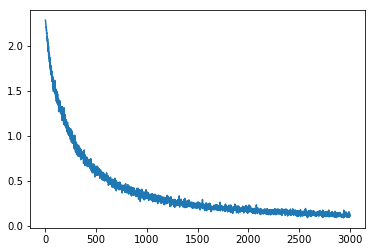

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

參考資料：
<li>https://github.com/ematvey/tensorflow-seq2seq-tutorials/blob/master/1-seq2seq.ipynb</li>
<li>http://blog.csdn.net/mao_xiao_feng/article/details/53382790</li>